# FoKL BSS-ANOVA Incremental Update Methodology

The purpose of this notebook is to break the ingestion of data from the experiment into multiple updates of the model.  For this, we will update the model twice, instead of on the first 10,000 seconds of data, we will train the initial model on the first 5,000 seconds of data, evaluate, and then add in the next 5,000 seconds for 10,000 total seconds of data.

In [1]:
# Import relevant libraries

# Data Processing
import pandas as pd
import numpy as np

# Modeling
from FoKL import FoKLRoutines

# Visualizations
import matplotlib.pyplot as plt

# Load in data
df = pd.read_csv('data/dataset1.csv')

## Part 1: Initial Training of Models
For this part, we are training on the first 5,000 seconds of data. This is half the data given to the previous models; so, we can intuitively expect a smaller training time; however, total training time will need to be evaluated for direct comparison.

In [2]:
# Create Models for the derivatives of h1 and h2
# built and update flags will need to be set to use the update functionality

GP_dh1_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500, tolerance = 1)
GP_dh1_model1.update = True # To use update methodology, must be called PRIOR to first fitting
GP_dh1_model1.built = False # Defines whether fresh model is created or prior model used
_ = GP_dh1_model1.fit(inputs = [df[['h1','h2','u']].iloc[:1000]], 
           data = df['h1_der'].iloc[:1000], 
           clean = True,
           minmax = [[0,10],[0,10],[0,3]]) 

GP_dh2_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500, tolerance = 1)
GP_dh2_model1.update = True # To use update methodology, must be called PRIOR to first fitting
GP_dh2_model1.built = False # Defines whether fresh model is created or prior model used
_ = GP_dh2_model1.fit(inputs = [df[['h1','h2','u']].iloc[:1000]], 
           data = df['h2_der'].iloc[:1000], 
           clean = True,
           minmax = [[0,10],[0,10],[0,3]])

1 -8467.686060453794
2 -8780.64106502572
2 -8904.672443192718
3 -9348.691336806465
3 -9487.574835832218
4 -9502.668774149335
4 -9538.139894059372
4 -9616.738360070209
5 -9583.390354032937
5 -9642.532998831239
5 -9686.386566237801
6 -9664.075878140899
6 -9644.999830551398
1 -9144.123192592542
2 -9494.585366664845
2 -9708.19890101373
3 -9953.630553528725
3 -10096.034663657918
4 -10103.145442033774
4 -10079.78414290201
4 -10047.010690917932


## Part 2: State Predictions with Initial Model

Now, lets make predictions.  These are expected to have some significant error since all the dynamics are not currently known with this limited dataset.

In [3]:
# Create vector of times and pump signals
tvec = df["time"].values
u = df['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = df["h1"].values[0]
h2[0] = df["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i] = np.clip(h1[i], GP_dh1_model1.minmax[0][0], GP_dh1_model1.minmax[0][1])
    h2[i] = np.clip(h2[i], GP_dh1_model1.minmax[1][0], GP_dh1_model1.minmax[1][1])
    h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True).item()
    h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True).item()
    
    if i % 250 == 0:
        print(i)

df['h1_prediction'] = h1
df['h2_prediction'] = h2

0
250
500
750
1000
1250
1500
1750
2000
2250


# Part 3: Initial Validation

We expect these predictions to be off due to the incomplete training data in the modeling of the dynamics, and they do leave much to be desired.

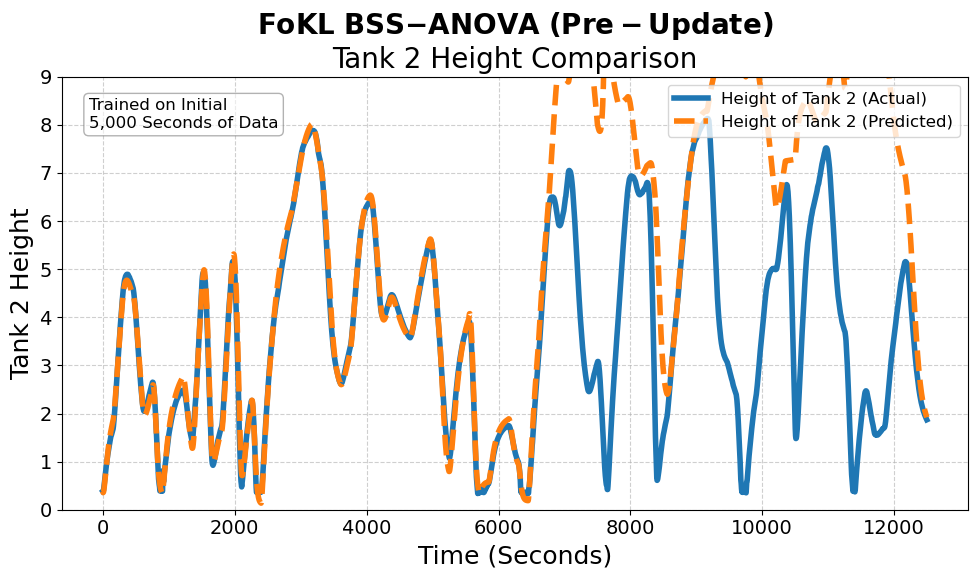

In [4]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(df['time'], df['h2'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(df['time'], df['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Pre-Update)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n5,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()

## Part 4: Model Update

Now that we have an initial training of the model, we can update it by only presenting the new data we want it to be trained on.  The previous model will serve as the prior, containing approximations of the initial training data due to the Bayesian nature of it.

In [5]:
# Create Models for the derivatives of h1 and h2
GP_dh1_model1.inputs = GP_dh1_model1.clean(df[['h1','h2','u']].iloc[1000:2000].to_numpy().tolist())
data_test = df['h1_der'].iloc[1000:2000].to_numpy()
GP_dh1_model1.data = np.expand_dims(data_test, axis = 0).T

# Second fitting
_ = GP_dh1_model1.fit()

# Create Models for the derivatives of h1 and h2
GP_dh2_model1.inputs = GP_dh2_model1.clean(df[['h1','h2','u']].iloc[1000:2000].to_numpy().tolist())
data_test = df['h2_der'].iloc[1000:2000].to_numpy()
GP_dh2_model1.data = np.expand_dims(data_test, axis = 0).T

# Second fitting
_ = GP_dh2_model1.fit()

same
5 -9485.089834679313
new
6 -7545.847120374534
new
6 -7504.84659511269
same
4 -10378.753795665287
new
4 -9914.277596512917
new
4 -9992.180793710217


# Part 5: State Predictions with Final Model

Using the new model with all the training data, we can make the state predictions.

In [6]:
# Create vector of times and pump signals
tvec = df["time"].values
u = df['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = df["h1"].values[0]
h2[0] = df["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i] = np.clip(h1[i], GP_dh1_model1.minmax[0][0], GP_dh1_model1.minmax[0][1])
    h2[i] = np.clip(h2[i], GP_dh1_model1.minmax[1][0], GP_dh1_model1.minmax[1][1])
    h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True).item()
    h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True).item()
    
    if i % 250 == 0:
        print(i)

df['h1_prediction'] = h1
df['h2_prediction'] = h2

0
250
500
750
1000
1250
1500
1750
2000
2250


# Part 6: Final Validation
Now, we can create a final validation of our model considering it has all of the training data.

In [7]:
MSE = np.sum((df['h2'][2000:-1] - df['h2_prediction'][2000:-1])**2)/len(df)
print('The MSE for the BSS-ANOVA Update Case is:', round(MSE,4))

The MSE for the BSS-ANOVA Update Case is: 0.0157


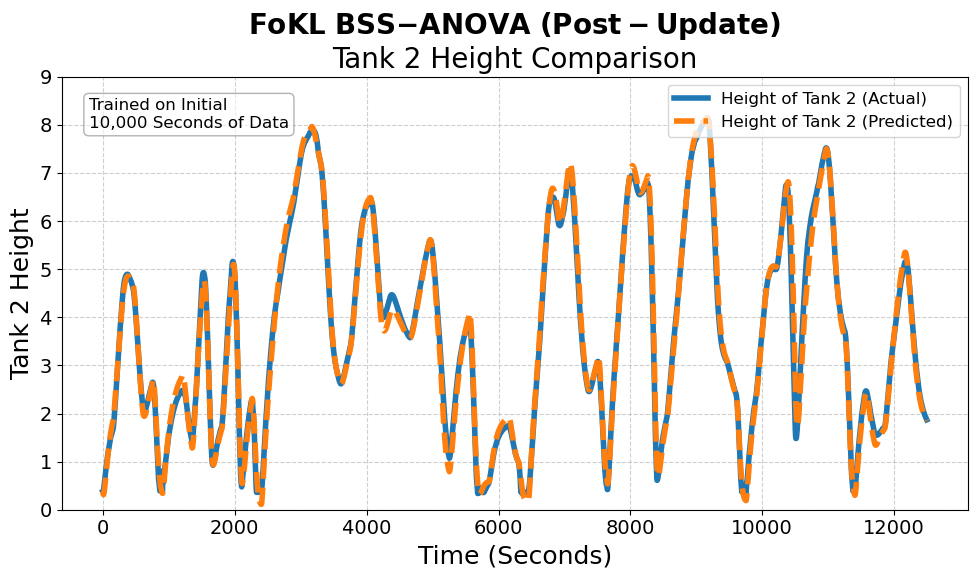

In [8]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(df['time'], df['h2'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(df['time'], df['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Post-Update)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()